### Implementation of Content-based Filtering

In [1]:
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser
from lenskit.algorithms.item_knn import ItemItem
from sklearn.manifold import TSNE
import plotly.express as px
from scipy.stats import pearsonr

In [2]:
data_folder = 'data/'
user_item_ratings_reduced = pd.read_csv(f'{data_folder}user_ratings_reduced.csv')
user_item_ratings_reduced = user_item_ratings_reduced.drop(columns=["Unnamed: 0"])
item_ratings_df = pd.read_csv(data_folder + 'user_ratings.csv')
item_info = pd.read_csv(data_folder + 'games.csv')
item_mecahnics = pd.read_csv(data_folder + 'mechanics.csv')
item_subcategories = pd.read_csv(data_folder + 'subcategories.csv')
item_themes = pd.read_csv(data_folder + 'themes.csv')

In [3]:
user_item_rating_count = user_item_ratings_reduced.groupby('user').count()

In [4]:
min_rating_count = 10
user_rating_count = user_item_rating_count[user_item_rating_count['rating'] >= min_rating_count]

In [5]:
user_list_filtered = list(user_rating_count.index)

In [6]:
user_item_ratings_filtered = user_item_ratings_reduced[user_item_ratings_reduced['user'].isin(user_list_filtered)]

In [7]:
user_item_ratings_filtered.head()

,item,rating,user
1,203416,8.0,-=Yod@=-
2,271896,8.0,-=Yod@=-
3,38054,6.0,-=Yod@=-
4,312267,5.0,-=Yod@=-
5,68448,9.0,-=Yod@=-


### Preprocessing

In [8]:
# item_ratings_df = pd.read_csv(data_folder + 'user_ratings.csv')
# item_info = pd.read_csv(data_folder + 'games.csv')
# item_mecahnics = pd.read_csv(data_folder + 'mechanics.csv')
# item_subcategories = pd.read_csv(data_folder + 'subcategories.csv')
# item_themes = pd.read_csv(data_folder + 'themes.csv')

In [9]:
item_info.rename(columns={'BGGId':'item'},inplace=True)

In [10]:
# get comeplete user-catalog data
user_item_complete = pd.merge(user_item_ratings_filtered, item_info, on='item', how='inner')

In [11]:
# item_info.info() 
# item_info[['GoodPlayers', 'Family', 'ImagePath']].head()
non_numerical_features = ['user','Name','Description', 'item', 'GoodPlayers', 'Family', 'ImagePath']

In [12]:
user_item_complete.columns

Index(['item', 'rating', 'user', 'Name', 'Description', 'YearPublished',
       'GameWeight', 'AvgRating', 'BayesAvgRating', 'StdDev', 'MinPlayers',
       'MaxPlayers', 'ComAgeRec', 'LanguageEase', 'BestPlayers', 'GoodPlayers',
       'NumOwned', 'NumWant', 'NumWish', 'NumWeightVotes', 'MfgPlaytime',
       'ComMinPlaytime', 'ComMaxPlaytime', 'MfgAgeRec', 'NumUserRatings',
       'NumComments', 'NumAlternates', 'NumExpansions', 'NumImplementations',
       'IsReimplementation', 'Family', 'Kickstarted', 'ImagePath',
       'Rank:boardgame', 'Rank:strategygames', 'Rank:abstracts',
       'Rank:familygames', 'Rank:thematic', 'Rank:cgs', 'Rank:wargames',
       'Rank:partygames', 'Rank:childrensgames', 'Cat:Thematic',
       'Cat:Strategy', 'Cat:War', 'Cat:Family', 'Cat:CGS', 'Cat:Abstract',
       'Cat:Party', 'Cat:Childrens'],
      dtype='object')

In [13]:
# find a median rating for each user
median_rating = user_item_complete.groupby('user')['rating'].median().rename('median_rating').reset_index()

In [14]:
user_item_complete = pd.merge(user_item_complete, median_rating, on='user', how='inner')

In [15]:
user_item_complete.shape

(1228331, 51)

User-Item matrix has size (1_228_331, 51) after selecting users with >= `min_rating_count`

User-Item matrix has size (771_551, 51) after selecting items for users with rating higher than their mean rating

In [16]:
user_item_favourite = user_item_complete[user_item_complete['rating']>=user_item_complete['median_rating']]

In [17]:
user_item_favourite['ComAgeRec'].fillna(user_item_favourite['ComAgeRec'].mean(), inplace=True)
user_item_favourite['LanguageEase'].fillna(user_item_favourite['LanguageEase'].mean(), inplace=True)

/var/folders/ys/q3jzjbwd6jv2_whcbxy4d7vh0000gn/T/ipykernel_26424/4043889100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_item_favourite['ComAgeRec'].fillna(user_item_favourite['ComAgeRec'].mean(), inplace=True)
/var/folders/ys/q3jzjbwd6jv2_whcbxy4d7vh0000gn/T/ipykernel_26424/4043889100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_item_favourite['LanguageEase'].fillna(user_item_favourite['LanguageEase'].mean(), inplace=True)


In [18]:
user_representation = user_item_favourite.groupby('user').median().reset_index()
user_representation_wnames = user_representation['user']
user_representation.drop(columns=['user'], inplace=True)

/var/folders/ys/q3jzjbwd6jv2_whcbxy4d7vh0000gn/T/ipykernel_26424/320511945.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  user_representation = user_item_favourite.groupby('user').median().reset_index()


In [19]:
user_item_favourite.drop(columns=non_numerical_features, inplace=True)

/var/folders/ys/q3jzjbwd6jv2_whcbxy4d7vh0000gn/T/ipykernel_26424/1451119071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_item_favourite.drop(columns=non_numerical_features, inplace=True)


In [20]:
user_representation

,item,rating,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,ComAgeRec,...,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens,median_rating
0,91536.0,8.0,2011.0,2.42170,7.639870,6.960180,1.355870,2.0,5.0,11.428571,...,21926.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.50
1,14550.5,6.0,2005.0,1.99675,7.004485,6.829525,1.385465,2.0,5.0,10.825521,...,21926.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00
2,65244.0,8.0,2010.0,2.35710,7.526640,7.187280,1.312320,2.0,5.0,10.285714,...,21926.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.50
3,15543.0,7.0,2003.0,1.78265,7.015380,6.285100,1.330330,2.0,5.5,10.333333,...,21926.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.00
4,160020.5,7.0,2014.0,3.00730,7.778710,7.022485,1.570085,2.0,5.0,11.548014,...,21926.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51144,57479.0,7.0,2009.5,2.91805,7.462140,7.072250,1.350125,2.0,5.0,11.588014,...,21926.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00
51145,181796.0,7.0,2016.0,2.47370,7.535430,7.134710,1.234990,2.0,4.0,10.947368,...,21926.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.00
51146,126163.0,7.0,2012.0,3.45860,7.867370,7.621750,1.266160,2.0,4.0,12.000000,...,21926.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00
51147,165986.0,7.0,2014.0,2.08330,7.164790,6.696380,1.307330,2.0,5.0,9.629032,...,21926.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.25


In [21]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=500)
user_clusters = tsne.fit_transform(user_representation)
time_end = time.time()

/var/folders/ys/q3jzjbwd6jv2_whcbxy4d7vh0000gn/T/ipykernel_26424/2369309741.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<AxesSubplot: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

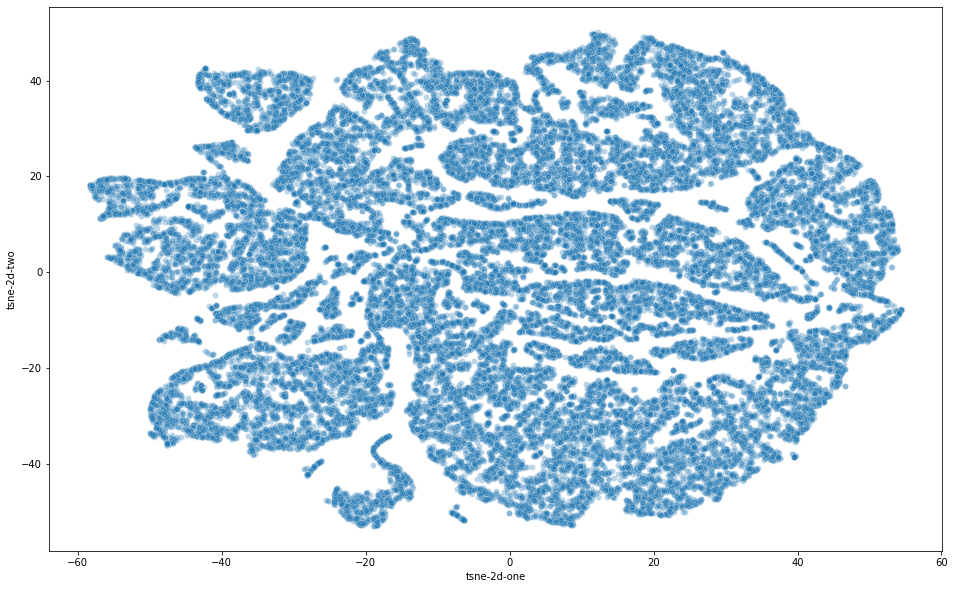

In [22]:
user_representation['tsne-2d-one'] = user_clusters[:,0]
user_representation['tsne-2d-two'] = user_clusters[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=user_representation,
    alpha=0.3,
)

In [23]:
# fig = px.scatter(
#     user_representation, x=user_representation['tsne-2d-one'], y=user_representation['tsne-2d-two'],
# )
# fig.show()

In [24]:
# manual cluster extraction using upper left and lower right points
group_1 = [(-11, 16), (12, 9.5)]
group_2 = [(-16, 9.5), (14, 0)]
group_3 = [(-15, 0), (15, -15)]

In [25]:
coords_groups = [group_1, group_2, group_3]
user_groups = []

for bounds in coords_groups:
    group_users = user_representation[(user_representation['tsne-2d-one'] >= bounds[0][0])&
                                      (user_representation['tsne-2d-one'] <= bounds[1][0])&
                                      (user_representation['tsne-2d-two'] <= bounds[0][1])&
                                      (user_representation['tsne-2d-two'] >= bounds[1][1])]
    user_groups.append(group_users)

In [26]:
group_1 = user_groups[0]
group_2 = user_groups[1]
group_3 = user_groups[2]

In [27]:
group_1 = pd.merge(group_1, user_representation_wnames, left_index=True, right_index=True, how='left')
group_2 = pd.merge(group_2, user_representation_wnames, left_index=True, right_index=True, how='left')
group_3 = pd.merge(group_3, user_representation_wnames, left_index=True, right_index=True, how='left')

In [28]:
all_users = pd.merge(user_representation, user_representation_wnames, left_index=True, right_index=True, how='left')

In [29]:
def get_all_items_for_user(username, complete_df):
    return complete_df[complete_df['user']==username].drop(columns=['user'])  

In [30]:
group_1_users = group_1.user
group_2_users = group_2.user
group_3_users = group_3.user

In [31]:
all_userids = all_users.user

In [32]:
group_1_itemids = user_item_complete[user_item_complete.user.isin(group_1_users)].item.unique()
group_1_items = user_item_complete[user_item_complete['item'].isin(group_1_itemids)]

group_2_itemids = user_item_complete[user_item_complete.user.isin(group_2_users)].item.unique()
group_2_items = user_item_complete[user_item_complete['item'].isin(group_2_itemids)]

group_3_itemids = user_item_complete[user_item_complete.user.isin(group_3_users)].item.unique()
group_3_items = user_item_complete[user_item_complete['item'].isin(group_3_itemids)]

In [33]:
all_user_itemids = user_item_complete[user_item_complete.user.isin(all_userids)].item.unique()
all_user_items = user_item_complete[user_item_complete['item'].isin(all_user_itemids)]

In [34]:
all_user_items.shape

(1228331, 51)

In [35]:
user_item_complete.shape

(1228331, 51)

In [36]:
def add_avg_group_rating(selected_items, group, complete):
    selected_items.reset_index(drop=True, inplace=True)
    selected_items['avg_group_rating'] = 0
    group_users = group['user'].unique()
    for index,item in selected_items.iterrows():
        item_in_group = complete[(complete['user'].isin(group_users))&(complete['item']==item['item'])]
        average_group_rating = item_in_group['rating'].mean()
        item['avg_group_rating'] = average_group_rating
        selected_items.iloc[index,:] = item
        
    return selected_items
        

In [37]:
item_group_1 = add_avg_group_rating(group_1_items.sample(frac=0.001, random_state=42), group_1, user_item_complete)
item_group_2 = add_avg_group_rating(group_2_items.sample(frac=0.001, random_state=42), group_2, user_item_complete)
item_group_3 = add_avg_group_rating(group_3_items.sample(frac=0.001, random_state=42), group_3, user_item_complete)
#item_group_1 = add_avg_group_rating(group_1_items.iloc[0:2,:], group_1, user_item_complete)

In [38]:
item_group_1[['Name','avg_group_rating']]

,Name,avg_group_rating
0,Fantasy Realms,7.833333
1,Acquire,6.944444
2,It Happens..,3.750000
3,Maracaibo,8.625000
4,Snow Tails,7.453333
...,...,...
970,Hanabi,7.302778
971,Rat Hot,5.000000
972,Spirit Island,8.285714
973,Small World,7.363375


In [39]:
# plt.figure(figsize=(16,16))
# sns.heatmap(item_group_3.corr())
# plt.title('Group 3 Correlation of Features')

In [40]:
def test_stat_significance(feature_name, selected_items):
    """ test whether an item feature has statistically significant 
        correlation (Pearson) with a group rating
    """

    feature = selected_items[feature_name].dropna()
    ratings = selected_items['avg_group_rating'].reindex(feature.index).values
    feature = feature.values
    
    r, p = pearsonr(ratings, feature)
    
    significant = False
    if p < 0.05:
        significant = True

    print(f'feature {feature_name} has p-value {round(p,2)}, significant: {significant}, correlation: {round(r,2)}')
    return r, significant
    

In [41]:
# test_stat_significance('MinPlayers',item_group_3)

In [42]:
def find_group_features(group_items, complete):
    features = group_items.columns
    group_features = []
    for feature_name in features:
        if feature_name in non_numerical_features:
            continue
        
        correlation, significant = test_stat_significance(feature_name, group_items)
        
        if significant and abs(correlation) > 0.25:
            group_features.append(feature_name)
    return group_features

In [43]:
group1_features = set(find_group_features(item_group_1, user_item_complete))
group2_features = set(find_group_features(item_group_2, user_item_complete))
group3_features = set(find_group_features(item_group_3, user_item_complete))

feature rating has p-value 0.0, significant: True, correlation: 0.29
feature YearPublished has p-value 0.03, significant: True, correlation: 0.07
feature GameWeight has p-value 0.0, significant: True, correlation: 0.26
feature AvgRating has p-value 0.0, significant: True, correlation: 0.63
feature BayesAvgRating has p-value 0.0, significant: True, correlation: 0.59
feature StdDev has p-value 0.0, significant: True, correlation: -0.3
feature MinPlayers has p-value 0.0, significant: True, correlation: -0.17
feature MaxPlayers has p-value 0.0, significant: True, correlation: -0.09
feature ComAgeRec has p-value 0.0, significant: True, correlation: 0.15
feature LanguageEase has p-value 0.0, significant: True, correlation: -0.2
feature BestPlayers has p-value 0.01, significant: True, correlation: 0.08
feature NumOwned has p-value 0.0, significant: True, correlation: 0.3
feature NumWant has p-value 0.0, significant: True, correlation: 0.48
feature NumWish has p-value 0.0, significant: True, c

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [44]:
group1_features.union(group2_features).union(group3_features)

{'AvgRating',
 'BayesAvgRating',
 'Cat:Strategy',
 'GameWeight',
 'MfgAgeRec',
 'NumOwned',
 'NumUserRatings',
 'NumWant',
 'NumWeightVotes',
 'NumWish',
 'Rank:boardgame',
 'Rank:strategygames',
 'StdDev',
 'avg_group_rating',
 'rating'}

In [45]:
group2_features


{'AvgRating',
 'BayesAvgRating',
 'Cat:Strategy',
 'GameWeight',
 'NumOwned',
 'NumUserRatings',
 'NumWant',
 'NumWeightVotes',
 'NumWish',
 'Rank:boardgame',
 'Rank:strategygames',
 'StdDev',
 'avg_group_rating',
 'rating'}

In [46]:
group3_features

{'AvgRating',
 'BayesAvgRating',
 'GameWeight',
 'MfgAgeRec',
 'NumOwned',
 'NumUserRatings',
 'NumWant',
 'NumWish',
 'Rank:boardgame',
 'StdDev',
 'avg_group_rating',
 'rating'}